In [2]:
import os
from pathlib import Path

import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.tensorboard.writer import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

from torchmetrics import Metric
from torchmetrics.classification import MultilabelF1Score
import pytorch_lightning as pl

from PIL import Image
import matplotlib.pyplot as plt

import random

import timm
from timm.optim import Lookahead

2023-03-17 03:22:20.285867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 03:22:21.174988: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/pe/papi/6.0.0.15/lib64:/opt/cray/libfabric/1.15.0.0/lib64
2023-03-17 03:22:21.175071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/pe/papi/6.0.0.15/lib64:/opt/cray/libfabric/1.15.0.0/

In [33]:
timm.list_models("*resnet18*", pretrained=False)[:20]

['gluon_resnet18_v1b',
 'legacy_seresnet18',
 'resnet18',
 'resnet18d',
 'seresnet18',
 'skresnet18',
 'ssl_resnet18',
 'swsl_resnet18']

## CFG

In [20]:
class CFG:
    # data
    dataset_dir = Path("/home/superai052/super_workspace/Data_train/dataset")
    train_csv = dataset_dir / "train.csv"
    val_csv = dataset_dir / "val.csv"
    test_csv = dataset_dir / "test.csv"
    
    # model
    model_name = "coatnet_3_rw_224"
    num_classes = 3
    learning_rate = 1e-3

    # trainer
    batch_size = 128
    shuffle = True
    num_workers = 16
    epoch = 30
    gpus = 1
    
    # save weight
    model_dir = Path("weights") / model_name
    model_path = model_dir / f"{model_name}_e{epoch}.pth"

## Create Class

### Data

In [21]:
class FRBDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        
        # Read the image using its absolute path
        image_path = row.path
        image = Image.open(image_path).convert("RGB")
        
        # Extract labels from the row
        labels = torch.tensor([row.pulse, row.broad, row.narrow], 
                              dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, labels

In [22]:
def unnormalize(image, mean, std):
    image_np = image.numpy().transpose((1, 2, 0))  # Convert tensor to NumPy array and rearrange channels
    image_np = (image_np * np.array(std)) + np.array(mean)  # Reverse normalization
    image_np = np.clip(image_np, 0, 1)  # Clip values to [0, 1] range
    return image_np

def visualize_transformed_images(dataset,
                                 mean,
                                 std, 
                                 num_images=9, 
                                 cols=3):
    rows = math.ceil(num_images / cols)
    random_img = random.sample(range(len(dataset)), num_images)
    
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    for i, img_idx in enumerate(random_img):
        row, col = divmod(i, cols)
        image, labels = dataset[img_idx]
        
        image_np = unnormalize(image, mean, std)  # Unnormalize the image
        axs[row, col].imshow(image_np, vmin=0., vmax=1.)
        axs[row, col].set_title(f"Labels: {labels}")
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()

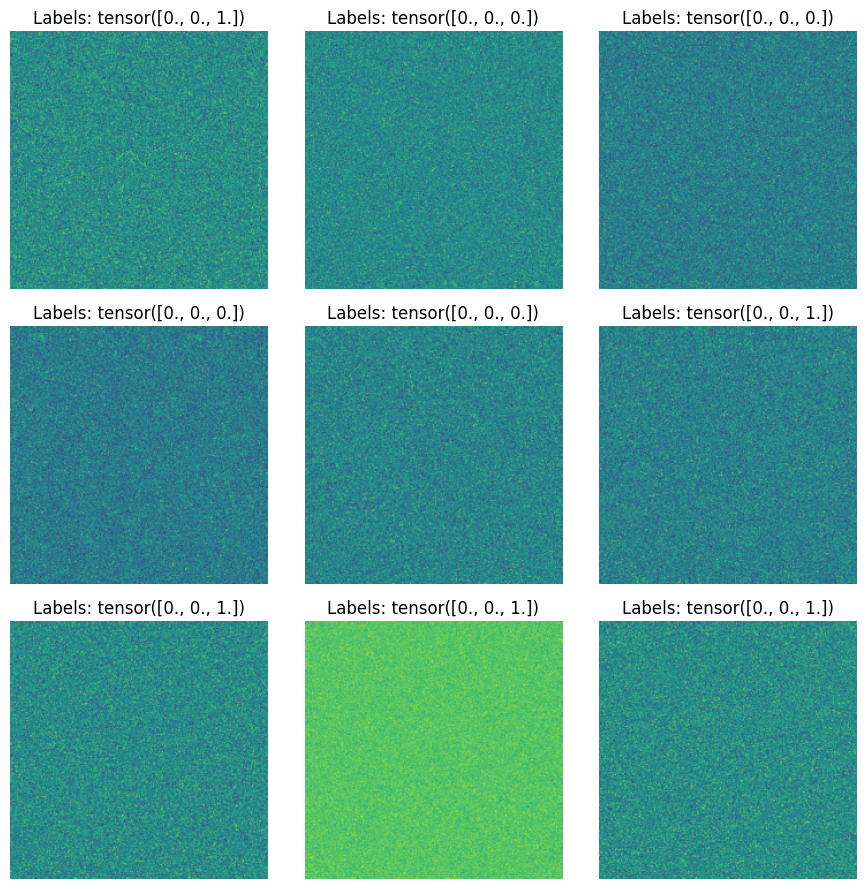

In [23]:
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std),
])

train_dataset = FRBDataset(CFG.train_csv, 
                           transform=transform)
visualize_transformed_images(train_dataset, 
                             mean=image_mean,
                             std=image_std,
                             num_images=9, 
                             cols=3)

In [24]:
val_dataset = FRBDataset(CFG.val_csv, 
                         transform=transform)

visualize_transformed_images(val_dataset,
                             mean=image_mean,
                             std=image_std,
                             num_images=9, 
                             cols=3)

In [25]:
test_dataset = FRBDataset(CFG.test_csv, 
                          transform=transform)
visualize_transformed_images(test_dataset, 
                             mean=image_mean,
                             std=image_std,
                             num_images=9, 
                             cols=3)

### Metric

In [26]:
class PulseRecall(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("true_positives", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("pulse_class_total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        preds = torch.sigmoid(preds) > 0.5
        
        mask = target[:, 0].bool()  # Only consider instances where the first class is present in the ground truth
        masked_preds = preds[mask]
        masked_target = target[mask]

        true_positives = (masked_preds[:, 0].bool() & masked_target[:, 0].bool()).sum()
        pulse_class_total = masked_target[:, 0].sum().long()

        self.true_positives += true_positives.item()
        self.pulse_class_total += pulse_class_total.item()

    def compute(self):
        pulse_class_recall = self.true_positives.float() / self.pulse_class_total.float()
        return pulse_class_recall


class FRBAccuracy(Metric):
    def __init__(self):
        super().__init__()
        self.add_state("correct", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("true_positives", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("pulse_class_total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        preds = torch.sigmoid(preds) > 0.5
        correct = (preds == target).sum()
        total_elements = target.numel()
        true_positives = (preds[:, 0].bool() & target[:, 0].bool()).sum()
        pulse_class_total = target[:, 0].sum().long()

        self.correct = self.correct + correct.item()
        self.total = self.total + total_elements
        self.true_positives = self.true_positives + true_positives.item()
        self.pulse_class_total = self.pulse_class_total + pulse_class_total.item()

    def compute(self):
        all_class_accuracy = self.correct.float() / self.total.float()
        pulse_class_recall = self.true_positives.float() / self.pulse_class_total.float()
        return pulse_class_recall * all_class_accuracy


# class FRBAccuracy(Metric):
#     def __init__(self):
#         self.add_state("c")

### Model

In [27]:
class MLPLayer(nn.Module):
    def __init__(self, input_size, output_size=3, hidden_sizes=None):
        super(MLPLayer, self).__init__()
        if hidden_sizes is None:
            hidden_sizes = [512, 256]

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:  # Add ReLU activation only between hidden layers
                layers.append(nn.ReLU())

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class TimmLightningModel(pl.LightningModule):
    def __init__(self, 
                 model_name='resnet18',
                 pretrained=False, 
                 num_classes=3, 
                 learning_rate=1e-3, 
                 hidden_dim=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = timm.create_model(model_name, 
                                       pretrained=pretrained, 
                                       num_classes=0)
        self.mlp = MLPLayer(input_size=self.model.num_features, 
                            output_size=num_classes,
                            hidden_sizes=hidden_dim)
        self.loss_fn = nn.BCEWithLogitsLoss()

        # accuracy
        self.train_f1 = MultilabelF1Score(
            num_labels=num_classes, 
            threshold=0.5, 
            average='weighted', 
            multidim_average='global')
        self.val_f1 = MultilabelF1Score(
            num_labels=num_classes, 
            threshold=0.5, 
            average='weighted', 
            multidim_average='global')
        
        # pulse recall
        self.train_pulse_recall = PulseRecall()
        self.val_pulse_recall = PulseRecall()
        
        # # remove
        # self.train_frb_accuracy = FRBAccuracy()
        # self.val_frb_accuracy = FRBAccuracy()

    def forward(self, x):
        x = self.model(x)
        x = self.mlp(x)
        return x

    def predict(self, x):
        logits = self.forward(x)
        prob = torch.sigmoid(logits)
        return prob
    
    def configure_optimizers(self):
        base_optimizer = torch.optim.Adam(self.parameters(), 
                                          lr=self.hparams.learning_rate)
        optimizer = Lookahead(base_optimizer)
        
        scheduler = ReduceLROnPlateau(optimizer,
                                      mode='max', 
                                      factor=0.1, 
                                      patience=10, 
                                      verbose=True)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_frb_accuracy",
            }
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_sig = torch.sigmoid(y_hat)
        
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', 
                 loss, 
                 on_step=False, 
                 on_epoch=True, 
                 logger=True, 
                 prog_bar=True)
        
        # accuracy
        self.train_f1(y_hat_sig, y)
        accuracy = self.train_f1.compute()
        self.log('train_f1', 
                 accuracy, 
                 on_step=False, 
                 on_epoch=True, 
                 logger=True, 
                 prog_bar=True)
        
        # pulse recall
        self.train_pulse_recall(y_hat, y)
        pulse_recall = self.train_pulse_recall.compute()
        self.log("train_pulse_recall",
                 pulse_recall,
                 on_step=False, 
                 on_epoch=True, 
                 logger=True,
                 prog_bar=True)
        
        # frb accuracy | pulse_recall * accuracy
        frb_accuracy = pulse_recall * accuracy
        self.log('train_frb_accuracy', 
                 frb_accuracy, 
                 on_step=False, 
                 on_epoch=True, 
                 logger=True,
                 prog_bar=True)
        
        
        # # remove
        # self.train_frb_accuracy(y_hat_sig, y)
        # self.log('train_frb_accuracy', 
        #          self.train_frb_accuracy, 
        #          on_step=False, 
        #          on_epoch=True, 
        #          logger=True,
        #          prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_sig = torch.sigmoid(y_hat)
        
        # loss
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', 
                 loss, 
                 on_step=False, 
                 on_epoch=True, 
                 logger=True, 
                 prog_bar=True)
        
        # accuracy
        self.val_f1(y_hat_sig, y)
        accuracy = self.val_f1.compute()
        self.log('val_f1', 
                 accuracy, 
                 on_step=False, 
                 on_epoch=True, 
                 logger=True, 
                 prog_bar=True)

        # pulse recall
        self.val_pulse_recall(y_hat, y)
        pulse_recall = self.val_pulse_recall.compute()
        self.log("val_pulse_recall",
                 pulse_recall,
                 on_step=False, 
                 on_epoch=True, 
                 logger=True,
                 prog_bar=True)
        
        
        # frb accuracy
        frb_accuracy = pulse_recall * accuracy
        self.log('val_frb_accuracy', 
                 frb_accuracy, 
                 on_step=False, 
                 on_epoch=True, 
                 logger=True,
                 prog_bar=True)

        # # remove
        # self.val_frb_accuracy(y_hat_sig, y)
        # self.log('val_frb_accuracy', 
        #          self.val_frb_accuracy, 
        #          on_step=False, 
        #          on_epoch=True, 
        #          logger=True,
        #          prog_bar=True)

    def test_step(self, batch, batch_idx):
        # Implement the test step if needed
        pass

In [28]:
model = TimmLightningModel(
    model_name=CFG.model_name,
    num_classes=CFG.num_classes,
    learning_rate=CFG.learning_rate,
)
model

TimmLightningModel(
  (model): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): BatchNormAct2d(
        96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Identity()
            )
            (pre_norm): BatchNormAct2d(
              192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (down): Identity()
            (conv1_1x1): Conv2d(192, 768, kernel_size=(1, 1), stride=(1

## Training

In [29]:
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=CFG.shuffle, num_workers=CFG.num_workers)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=CFG.shuffle, num_workers=CFG.num_workers)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=CFG.shuffle, num_workers=CFG.num_workers)

In [30]:
model = TimmLightningModel(
    model_name=CFG.model_name,
    num_classes=CFG.num_classes,
    learning_rate=CFG.learning_rate,
)

In [31]:
trainer = pl.Trainer(
    max_epochs=CFG.epoch,
    gpus=CFG.gpus
)

/home/superai052/.conda/envs/work/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/superai052/.conda/envs/work/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/superai052/.conda/envs/work/lib/python3.8/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
    )

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /lustrefs/disk/project/lt900011-ai2310/dataset/dataset_v1/lightning_logs


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

## Evaluate

In [ ]:
trainer.validate(model=model,
                 dataloaders=test_loader)

## Save Model

In [ ]:
CFG.model_dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), CFG.model_path)